In [1]:
import pandas as pd
import yfinance as yf
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
class trendist_v2:
    """
    #### Description
    trendist_v2 is a financial trend analysis class designed to retrieve, analyze, and visualize historical 
    stock data using Yahoo Finance. The class focuses on calculating and plotting price history, 
    return distributions, and cumulative distributions, as well as assessing the likelihood of trend 
    continuation. Key functionalities include plotting historical price data, visualizing return 
    distributions, and calculating probabilities of future returns based on past trends.

    #### Attributes:
        ticker (str): The stock ticker symbol for which data will be retrieved.
        period (str): The period over which to retrieve historical data (default is '10y').
        timeperiod (str): The resampling period for data, such as daily ('D'), weekly ('W'), or monthly ('M').

    #### Methods:
        plot_history(): Plots the historical closing price of the asset using a logarithmic scale, 
                        providing a clear view of price changes over time.
        
        plot_distrib(): Plots a histogram of the returns distribution and overlays a fitted normal 
                        distribution curve. It highlights the latest return value with a dashed line.
        
        get_proba(): Calculates the probability of trend continuation based on recent returns, 
                     using a Kolmogorov-Smirnov test to check normal distribution fit. Outputs a 
                     DataFrame summarizing key metrics and trend statistics.
        
        plot_cumdistrib(): Plots the cumulative distribution of returns, highlighting the last return
                           and overlaying an empirical cumulative distribution function (ECDF) for 
                           additional insights into the probability of specific return levels.
    """
    
    def __init__(self, ticker, period='10y', timeperiod='W'):
        # Initialize the class with the ticker symbol, period, and time period for data resampling
        self.ticker = ticker
        self.timeperiod = timeperiod
        
        # Retrieve historical data for the specified ticker and period, focusing on 'Close' prices
        history = yf.Ticker(self.ticker).history(period)['Close']
        
        # Standardize the date format in the index and resample the data based on the specified time period
        history.index = pd.to_datetime(history.index.date)
        self.history = history.resample(self.timeperiod).last()
        
        # Calculate returns as the percentage change in 'Close' prices, removing any missing data
        self.returns = self.history.pct_change().dropna()

    def plot_history(self):
        # Plot the historical price data using a log scale on the y-axis
        plt.figure(figsize=(12, 4))
        plt.plot(self.history, label=self.ticker, color='blue', linewidth=1)
        plt.title(f'{self.ticker} - Price and History')
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_distrib(self):
        # Plot the histogram of returns and overlay a fitted normal distribution
        returns = self.returns
        ticker = self.ticker
        last_trend = returns.iloc[-1]  # Capture the most recent return value
        
        plt.figure(figsize=(12, 4))
        
        # Plot histogram of returns with specified bin size and formatting
        plt.hist(
            returns, 
            bins=35, 
            density=True, 
            alpha=0.7, 
            color='blue', 
            edgecolor='black', 
            label=ticker
        )

        # Fit a normal distribution to returns and plot its probability density function (PDF)
        mean, std = stats.norm.fit(returns)
        x = np.linspace(returns.min(), returns.max(), 100)
        y = stats.norm.pdf(x, mean, std)
        
        plt.plot(x, y, 'r-', lw=1, label='Normal pdf')
        
        # Highlight the most recent return with a vertical dashed line
        plt.axvline(
            x=last_trend, 
            color='red', 
            linestyle='dashed', 
            linewidth=1, 
            label='Last trend'
        )
        
        plt.ylabel('Frequency')
        plt.title(f'{ticker} - Distribution Chart')
        plt.grid(True)
        plt.legend()
        plt.show()

    def get_proba(self):
        # Calculate statistical information and probability of continuation based on returns
        returns = self.returns
        ticker = self.ticker
        
        # Filter returns for positive or negative trends, based on the last observed return
        if returns.iloc[-1] > 0:
            returns = returns[returns > 0]
        else:
            returns = returns[returns < 0]

        # Fit a normal distribution to filtered returns and perform a KS test to evaluate fit
        mean, std = stats.norm.fit(returns)
        ks_statistic, ks_p_value = stats.kstest(returns, 'norm', (mean, std))

        # Calculate the probability of continuation given the last return's sign
        if returns.iloc[-1] > 0:
            proba = stats.norm.sf(returns.iloc[-1], mean, std)
        else:
            proba = 1 - stats.norm.sf(returns.iloc[-1], mean, std)

        # Summarize statistical descriptors for the returns distribution
        trend_description = returns.describe().round(4).to_dict()

        # Compile data into a structured dictionary for output as a DataFrame
        data = {
            'Metric': [
                'Ticker', 
                'Last return',
                'Mean',
                'Standard Deviation', 
                'KS Statistic', 
                'KS P-value', 
                'Continuation proba', 
                'Count', 
                'Mean (desc)', 
                'Std (desc)', 
                'Min', 
                '25%', 
                '50%', 
                '75%', 
                'Max'
            ],
            'Value': [
                ticker, 
                "{:.2f}%".format(returns.iloc[-1] * 100),
                "{:.2f}%".format(mean * 100),
                "{:.2f}%".format(std * 100),
                "{:.2f}%".format(ks_statistic * 100),
                "{:.2f}%".format(ks_p_value * 100),
                "{:.2f}%".format(proba * 100),
                "{:.0f}".format(trend_description['count']),
                "{:.2f}%".format(trend_description['mean']*100),
                "{:.2f}%".format(trend_description['std']*100),
                "{:.2f}%".format(trend_description['min']*100),
                "{:.2f}%".format(trend_description['25%']*100),
                "{:.2f}%".format(trend_description['50%']*100),
                "{:.2f}%".format(trend_description['75%']*100),
                "{:.2f}%".format(trend_description['max']*100),
            ]
        }

        # Convert data into a DataFrame, setting 'Metric' as the index for readability
        df = pd.DataFrame(data).set_index('Metric')
        print(df)
    
    def plot_cumdistrib(self):
        # Plot the cumulative distribution of returns
        returns = self.returns
        ticker = self.ticker

        # Filter positive or negative returns based on the last return
        if returns.iloc[-1] > 0:
            returns = returns[returns > 0]
            complementary = True
        else:
            returns = returns[returns < 0]
            complementary = False

        # Fit a normal distribution to the filtered returns
        mean, std = stats.norm.fit(returns)
        x = np.linspace(returns.min(), returns.max(), 100)
        
        # Calculate cumulative distribution and normalize it
        y = stats.norm.pdf(x, mean, std).cumsum()
        y /= y[-1]  # Normalization
        if returns.iloc[-1] > 0:
            y = 1 - y  # Adjust for positive return trends

        # Plot cumulative distribution function (CDF)
        plt.figure(figsize=(12, 4))
        plt.plot(x, y, label="Distribution pdf", color='red', linewidth=1)

        # Plot empirical cumulative distribution function (ECDF) with option for complementary CDF
        plt.ecdf(returns, complementary=complementary, label="RCDF", color='blue')

        # Highlight the most recent return with a dashed vertical line
        plt.axvline(
            x=returns.iloc[-1], 
            color='red', 
            linestyle='dashed', 
            linewidth=1, 
            label='Last trend'
        )

        plt.title(f"{ticker} - Cumulative Distribution Chart")
        plt.xlabel("Length")
        plt.ylabel("Probability of occurrence")
        plt.grid(True)
        plt.legend()
        plt.show()


Text(value='AAPL', description='Ticker:')

Dropdown(description='Period:', index=2, options=('1y', '5y', '10y', 'max'), value='10y')

Dropdown(description='Time Period:', index=1, options=('D', 'W', 'M'), value='W')

Button(description='Generate Plots', style=ButtonStyle())

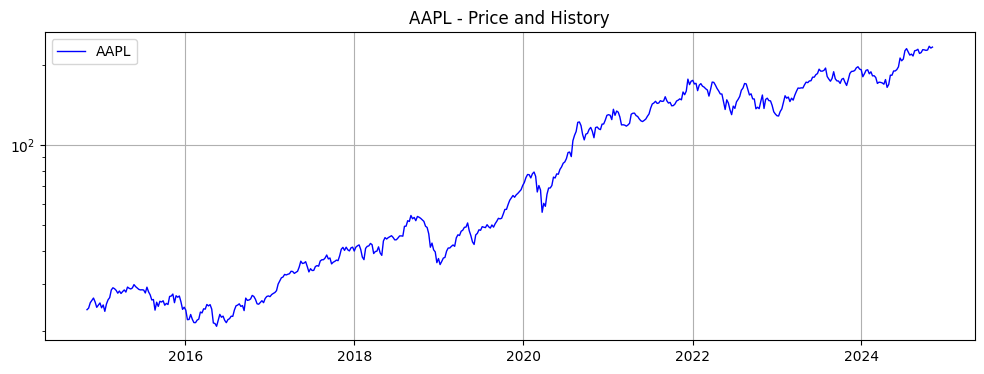

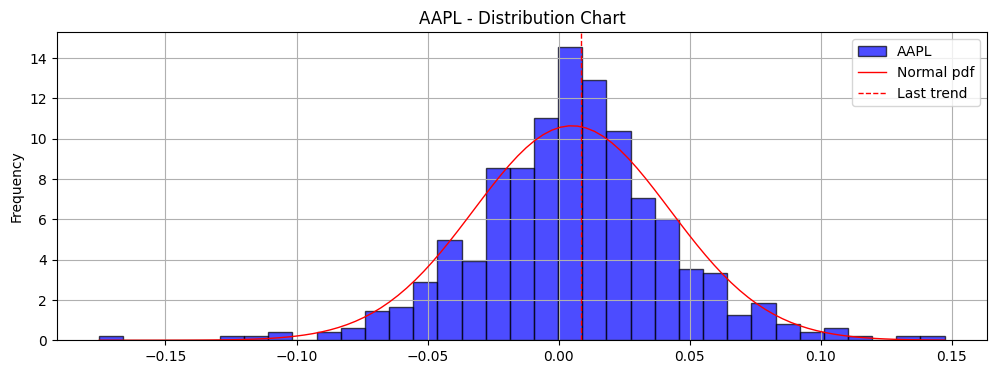

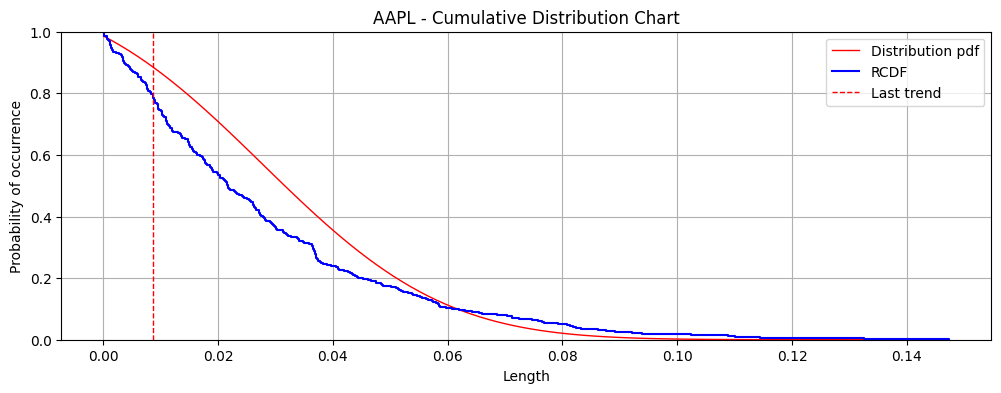

                     Value
Metric                    
Ticker                AAPL
Last return          0.86%
Mean                 2.86%
Standard Deviation   2.50%
KS Statistic        12.70%
KS P-value           0.01%
Continuation proba  78.78%
Count                  305
Mean (desc)          2.86%
Std (desc)           2.50%
Min                  0.01%
25%                  0.96%
50%                  2.17%
75%                  3.79%
Max                 14.73%


In [3]:
# Widget setup
ticker_widget = widgets.Text(value='AAPL', description='Ticker:', disabled=False)
period_widget = widgets.Dropdown(options=['1y', '5y', '10y', 'max'], value='10y', description='Period:')
timeperiod_widget = widgets.Dropdown(options=['D', 'W', 'M'], value='W', description='Time Period:')
button = widgets.Button(description="Generate Plots")

# Function to update instance and display plots
def on_button_click(b):
    clear_output()  # Clears previous output
    display(ticker_widget, period_widget, timeperiod_widget, button)  # Re-displays the widgets
    
    ticker = ticker_widget.value
    timeperiod = timeperiod_widget.value
    period = period_widget.value
    trend = trendist_v2(ticker, period, timeperiod)
    trend.plot_history()
    trend.plot_distrib()
    trend.plot_cumdistrib()
    trend.get_proba()

# Link button to the function
button.on_click(on_button_click)

# Display widgets
display(ticker_widget, period_widget, timeperiod_widget, button)